In [264]:
from lib.data import Mimic2
from lib.model import MLP
import numpy as np
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss, wridge, wlasso, lasso, ridge, owl, r4rr
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, reg_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from lib.openbox import open_box, count_config, find_x, open_box_batch, find_all_x

In [361]:
raw_data = []
for fn in glob.glob('models/*.pkl'):
    name = fn.split('/')[-1].split('.pkl')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])

df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(rec, prec)', 'sparsity'])
print(df.sort_values(['auc'], ascending=False))

   method name   alpha       auc        ap  min(rec, prec)  sparsity
21    wlasso3*    0.01  0.828827  0.697460        0.462069  0.287939
17    wridge3*     0.1  0.821438  0.733660        0.413793  0.108832
19       lasso    0.01  0.816504  0.161707        0.432692  0.067501
28     wlasso3   0.001  0.812708  0.225787        0.461538  0.059318
25    eye_loss   0.001  0.810372  0.170944        0.428571  0.050809
22      wlasso    0.01  0.808972  0.404536        0.471154  0.116692
11       lasso     0.1  0.806896  0.159915        0.461538  0.458158
29      wridge   0.001  0.803420  0.132820        0.415094  0.048295
23     wlasso3  0.0001  0.803391  0.147703        0.423077  0.046209
2    eye_loss*    0.01  0.803112  0.681404        0.413333  0.193344
1      wlasso3   1e-05  0.798925  0.135969        0.462264  0.039623
12     wlasso3    0.01  0.797392  0.614649        0.433962  0.197588
27      wridge  0.0001  0.796812  0.130134        0.423077  0.025344
18      wlasso   0.001  0.795323  

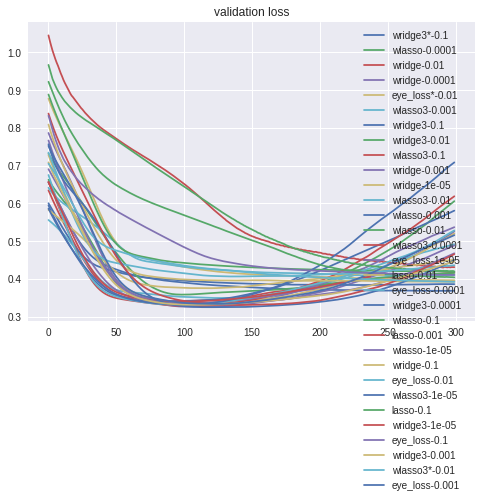

In [353]:
for fn in glob.glob('models/*.valloss.npy'):
    name = fn.split('/')[-1].split('.valloss')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    losses = np.load(fn)
    plt.title("validation loss")
    plt.plot(losses, label="%s-%s" % (name, alpha))
    
plt.legend()
plt.show()

# find out how many classifiers (LLC) are there

In [304]:
m = Mimic2(duplicate=3)
train_data = TensorDataset(*map(lambda x: x.data, prepareData(m.xtrain, m.ytrain)))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [347]:
net = torch.load('models/wlasso_dup3_0.01^0.01.pt')
config_counter = count_config(net, train_loader)

100%|██████████| 36/36 [00:02<00:00, 16.01it/s]


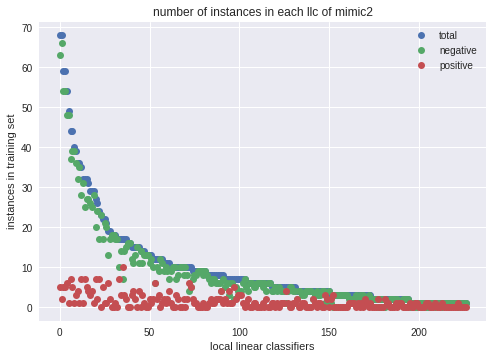

In [348]:
sorted_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), 
                                    config_counter.items()), 
                                key=lambda x: x[1], reverse=True)

plt.plot(list(map(lambda x: x[1], sorted_configs)), 'o', label='total')
plt.plot(list(map(lambda x: x[2], sorted_configs)), 'o', label='negative')
plt.plot(list(map(lambda x: x[3], sorted_configs)), 'o', label='positive')

plt.title('number of instances in each llc of mimic2')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')
plt.legend()
plt.show()

In [349]:
top = 0
x = find_all_x(sorted_configs[top][0], net, train_loader)

In [350]:
len(sorted_configs), len(m.xtrain)

(227, 2250)

/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


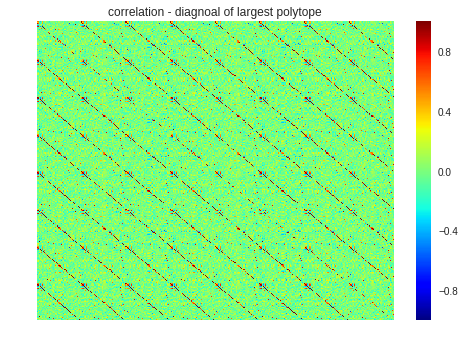

In [290]:
corr = np.corrcoef(x.data.numpy().T) # m.xtrain.T
plt.title('correlation - diagnoal of largest polytope')
sns.heatmap(corr - np.diag(np.diag(corr)), cmap='jet')
plt.axis('off')
plt.show()

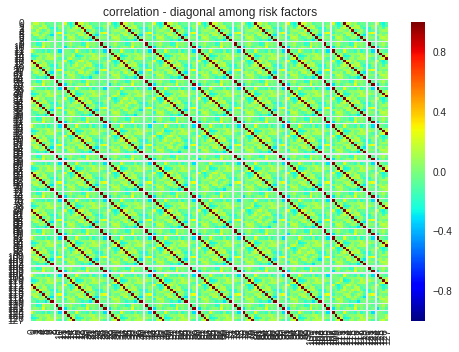

In [291]:
indices = m.r.nonzero().view(-1)
sub_corr = corr[indices][:, indices]
sns.heatmap(sub_corr - np.diag(np.diag(sub_corr)), cmap='jet', vmin=-1, vmax=1)
plt.title('correlation - diagonal among risk factors')
plt.show()

In [351]:
W, b, C = open_box(net, x[0])

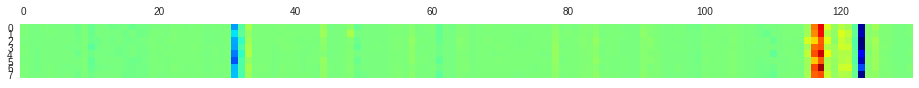

In [352]:
expl = (W[1] - W[0]).data.numpy()
expl_max = np.max(np.abs(expl))
plt.matshow(expl.reshape(8,-1),cmap='jet', vmin=-expl_max, vmax=expl_max)
plt.grid(False)
plt.show()

# How openbox is different from gradient

In [327]:
f = MLP([1, 10, 20, 1], activation=torch.nn.ReLU)

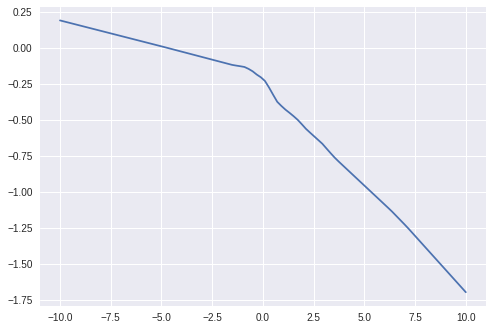

In [328]:
n = 100
x = torch.linspace(-10, 10, n).reshape(n, 1)
plt.plot(x.view(-1).data.numpy(), f(x).view(-1).data.numpy())
plt.show()

In [329]:
samples = torch.FloatTensor([-5, 0, 5]).view(-1,1)
Ws, bs, Cs = open_box_batch(f, samples)

In [330]:
Ws

[tensor([[-0.0360]], grad_fn=<MmBackward>),
 tensor([[-0.1313]], grad_fn=<MmBackward>),
 tensor([[-0.1319]], grad_fn=<MmBackward>)]